In [1]:
%reload_ext autoreload
%autoreload 2  

# Load data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_name = "IrishNationalTideGaugeNetwork_8eaa_cdad_02f5.csv"
file_name_big = "IrishNationalTideGaugeNetwork_070c_f250_eaf8.csv"

# file_name = file_name_big


df = pd.read_csv(file_name)
df.drop(columns=['latitude', 'longitude', 'Water_Level_OD_Malin'], inplace=True)
df = df.iloc[1:]
df['Water_Level_LAT'] = df['Water_Level_LAT'].astype(float)
mean_every_12_rows = df.groupby(df.index // 12)['Water_Level_LAT'].mean()

mean_every_12_rows

0      3.091273
1      2.602500
2      2.193083
3      2.006667
4      2.120333
         ...   
163    1.263250
164    1.791250
165    2.539833
166    3.213000
167    3.627400
Name: Water_Level_LAT, Length: 168, dtype: float64

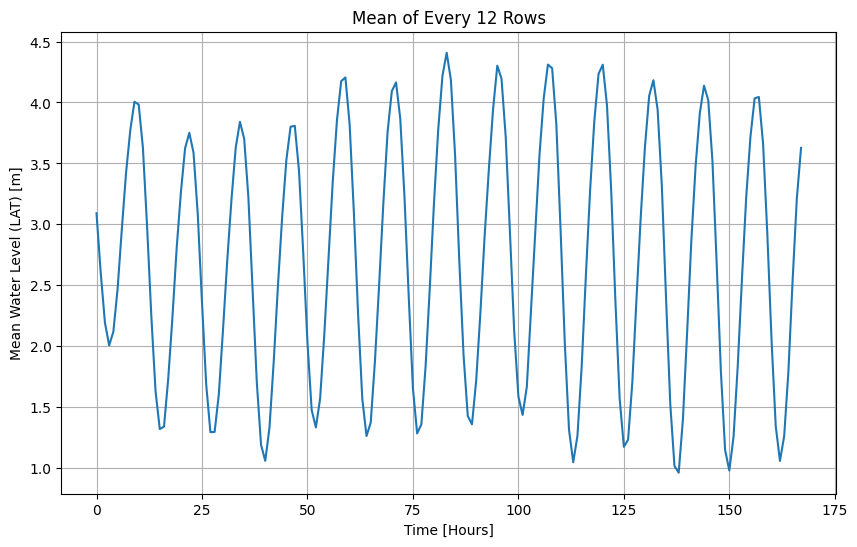

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(mean_every_12_rows.index, mean_every_12_rows.values)
plt.title('Mean of Every 12 Rows')
plt.xlabel('Time [Hours]')
plt.ylabel('Mean Water Level (LAT) [m]')
plt.grid(True)
plt.show()

# Expectation matrix

### Format data

In [4]:
import numpy as np
data = np.array(mean_every_12_rows)
print(data.shape)
print(data[0])

# Rescale the data to be between 0 and 2np.pi
data = (data - data.min())/(data.max() - data.min()) * 2 * np.pi
data[150]

# get training data
train_x = data[:-30]
print(train_x.shape)

# get test data
test_x = data[-30:]
print(test_x.shape)

(168,)
3.091272727272727
(138,)
(30,)


In [5]:
m = 8

n = (m-1)*5

train_matrix = np.tile(train_x, (n, 1)).transpose()
print("train_matrix.shape: ", train_matrix.shape)
train_matrix[:2] 

# prediction matrix
test_matrix = np.tile(test_x, (n, 1)).transpose()
print("test_matrix.shape: ", test_matrix.shape)

train_matrix.shape:  (138, 35)
test_matrix.shape:  (30, 35)


### Generate circuit object

In [46]:
import perceval as pcvl
import lo_reservoir as lrs

t_max_train = train_x.shape[0]
memory_length = 7

simulator = lrs.PhotonicReservoirSimulator(m, t_max_train, overlapping=True)

# generate the layers
_ = simulator.set_circuit_with_stored_layers()

Generating layers: 100%|██████████| 138/138 [00:00<00:00, 354.50it/s]


In [47]:
input_state = pcvl.BasicState([1]*(m-1) + [0]*1)
# input_state = pcvl.BasicState([0, 1, 0, 1, 0, 1, 0, 1])
# train_expectation_matrix = simulator.sequential_expectation_with_memory(train_matrix, 
#                                                                         input_state, memory_length=memory_length)
train_expectation_matrix = simulator.sequential_expectation_calculation(train_matrix, 
                                                                        input_state)
print("expectations_matrix.shape = ", np.array(train_expectation_matrix).shape)

Processing time steps: 100%|██████████| 138/138 [00:08<00:00, 16.84it/s]

expectations_matrix.shape =  (138, 8)


In [48]:
import perceval as pcvl
import lo_reservoir as lrs

t_max_test = test_x.shape[0]

simulator = lrs.PhotonicReservoirSimulator(m, t_max_test, overlapping=True)

# generate the layers
_ = simulator.set_circuit_with_stored_layers()

Generating layers: 100%|██████████| 30/30 [00:00<00:00, 395.66it/s]


In [49]:

# test_expectation_matrix = simulator.sequential_expectation_with_memory(test_matrix, 
#                                                                         input_state, memory_length=memory_length)

test_expectation_matrix = simulator.sequential_expectation_calculation(test_matrix, 
                                                                        input_state)
print("expectations_matrix.shape = ", np.array(test_expectation_matrix).shape)

Processing time steps:   0%|          | 0/30 [00:00<?, ?it/s]

Processing time steps: 100%|██████████| 30/30 [00:00<00:00, 32.50it/s]

expectations_matrix.shape =  (30, 8)


# Quadratic Regression

In [54]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Assuming 'train_expectation_matrix' and 'train_x' are defined and available

# Pop the last row of expectations_matrix
expectations_matrix_red = np.array(train_expectation_matrix)[:-1]
print("expectations_matrix.shape = ", expectations_matrix_red.shape)

# Make prediction vector
labels = np.array(train_x)[1:]
data_red = np.array(train_x)[1:]
print("labels:", labels[:3])
print("data_red: ", data_red[:4])
print("labels shape: ", labels.shape)

# Transform the data to include quadratic terms
poly = PolynomialFeatures(degree=20)
expectations_matrix_quad = poly.fit_transform(expectations_matrix_red)

# Fit the quadratic model with Ridge regularization
# You can adjust the alpha parameter to control the strength of the regularization
reg_ridge = Ridge(alpha=2).fit(expectations_matrix_quad, labels)

# 'reg_ridge' is now a Ridge regression model fit to the quadratic terms


expectations_matrix.shape =  (137, 8)
labels: [2.99056039 2.24405987 1.9041613 ]
data_red:  [2.99056039 2.24405987 1.9041613  2.11141282]
labels shape:  (137,)


In [55]:
test_expectation_matrix_quad = poly.fit_transform(test_expectation_matrix)

# Make predictions using the quadratic model
predicted_data_quad = reg_ridge.predict(test_expectation_matrix_quad)
print("predicted_data.shape = ", predicted_data_quad.shape)

# Rescale the prediction data (if necessary)
# Assuming 'rescale' is a function or a method you have defined for rescaling
# rescaled_predicted_data = rescale(predicted_data_quad)

# Print predictions
print(predicted_data_quad)

# If you want to compare with the actual test values (if available)
print(test_x)

predicted_data.shape =  (30,)
[ 2.98885185  2.98885185  6.33449599 -4.89666429 17.87893673  5.10728541
  3.02317999 -3.99991355  0.05583822 -1.44645439 11.87058304  5.0040928
  2.8948963   2.83884372  7.60467511 10.09324085 -4.38803291  4.12894555
  9.26919016  4.13861709  9.54115394 10.60965636 -0.06530032  5.98155135
 -4.28021318 -7.55610202 -6.04433957  0.58818775  4.34695008  4.83183362]
[0.         0.79998478 2.10503118 3.47647707 4.58202109 5.37729561
 5.79027921 5.57497466 4.66012027 3.13126047 1.51366541 0.33822718
 0.03281989 0.539249   1.60543954 2.90851067 4.12056738 5.02205071
 5.6014129  5.62162145 4.92055216 3.58071061 1.99411211 0.69635902
 0.17655884 0.54866952 1.51138625 2.87629856 4.10370161 4.85928837]


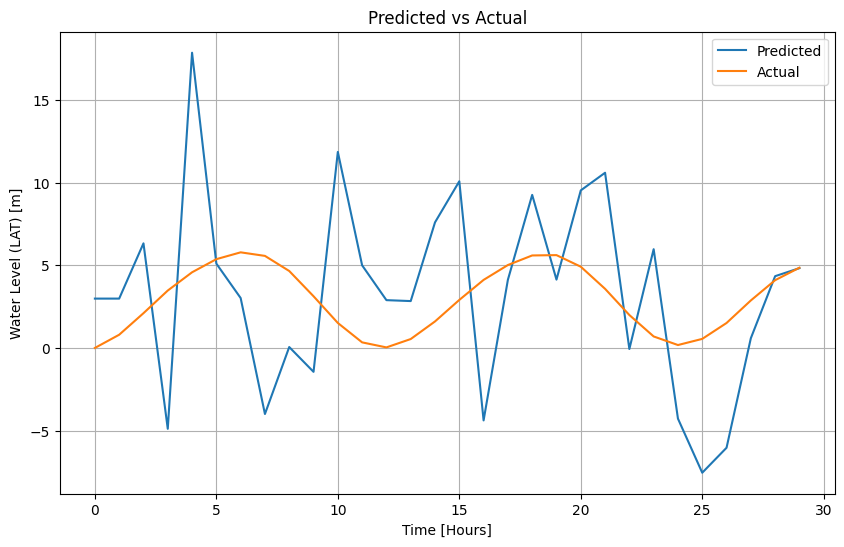

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predicted_data_quad, label='Predicted')
plt.plot(test_x, label='Actual')
plt.title('Predicted vs Actual')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.grid(True)


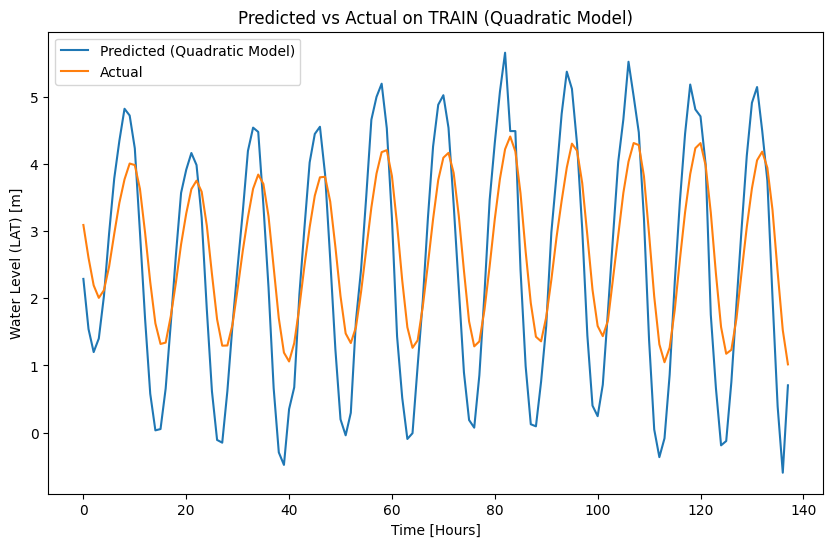

In [57]:
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Assuming 'reg_quad' is your trained quadratic model and 'train_expectation_matrix' is available

# Transform the training data to include quadratic terms
train_expectation_matrix_quad = poly.fit_transform(train_expectation_matrix)

# Make predictions using the quadratic model
predicted_train_data_quad = reg_ridge.predict(train_expectation_matrix_quad) - 0.7

# Assuming 'other_data' is already defined and represents the actual values
other_data = mean_every_12_rows[:-30]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(predicted_train_data_quad, label='Predicted (Quadratic Model)')
plt.plot(other_data, label='Actual')
plt.title('Predicted vs Actual on TRAIN (Quadratic Model)')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.show()
